In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
#for removing warnings
import warnings

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path1 = 's3://data/CREG12.L75-REF08_mesh_zgr.zarr'
data_path2 = 's3://data/vel_dataIII.zarr/vel_dataIII.zarr'
data_path3 = 's3://data/lat_lon_scalar.zarr'

remote_files1 = fsg.glob(data_path1)
remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store1 = s3fs.S3Map(root=data_path1, s3=fsg, check=False)
store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

dzz = xr.open_zarr(store=store1, consolidated=True)
dv = xr.open_zarr(store=store2, consolidated=True)
dl = xr.open_zarr(store=store3, consolidated=True)

In [3]:
bathym = dzz.mbathy.isel(x=slice(200,1400),y=slice(650,1800))

In [4]:
lat = dzz.nav_lat.isel(x=slice(200,1400),y=slice(650,1800))
lon = dzz.nav_lon.isel(x=slice(200,1400),y=slice(650,1800))
lon_flat = dzz.nav_lon.isel(x=slice(200,1400),y=slice(650,1800)).values.flatten()
lat_flat = dzz.nav_lat.isel(x=slice(200,1400),y=slice(650,1800)).values.flatten()

# Prøver å finne y,x index for mooringene 

In [5]:
p_list = [(31.13247,81.24202),(31.13533,81.24255),(31.14506,81.24587)
          ,(011.1189, 69.5289),(013.16845,68.58759),(013.19866,68.56109),(012.45082,68.50128)
          ,(5.57541,79.37209),(5.48733,80.03876),(5.56333,79.44093)
          ,(-152.04848,71.39398),(-152.04848,71.39398),(-152.05077,71.39432),(-152.05066,71.39435)]

In [5]:
'Updated p_list, adding chukchi sea moorings'
 #[(31.13247,81.24202),(31.13533,81.24255),(31.14506,81.24587)
          #,(011.1189, 69.5289),(013.16845,68.58759),(013.19866,68.56109),(012.45082,68.50128)
          #,(5.57541,79.37209),(5.48733,80.03876),(5.56333,79.44093)
          #,(-152.04848,71.39398),(-152.04848,71.39398),(-152.05077,71.39432),(-152.05066,71.39435)
#p_list = [(-160.4923,72.121),(-159.1216,72.1628),(-158.5512,72.1815),(-163.5346,72.2808),(-164.0992,72.5252)]
p_list = [(24.00000,81.24925),
          (18.29052,81.10979),
          (23.59853,81.30813),
          (18.23789,81.22686),
          (23.59982,81.35453),
          (18.23730,81.27356)]

In [104]:
print(f'punkter jeg er ferdig med er :{p_list[4]}, neste punkter er {p_list[5]}')
p = p_list[5]

punkter jeg er ferdig med er :(23.59982, 81.35453), neste punkter er (18.2373, 81.27356)


# Trying to find the closest latitude value and longitude value in the model to the moorings lat lon 
lat_value = [min(lat_flat, key=lambda x:abs(x-h)) for h in [p[1]]]
lon_value = [min(lon_flat, key=lambda x:abs(x-h)) for h in [p[0]]]
print('lat value closest to point ', p[1],'is ', lat_value)
print('lon value closest to point ', p[0],'is ', lon_value)

In [105]:
# Trying to find the x,y index to lat,lon value in the model 
idx_lat = np.where(lat.values==lat_value)
idx_lon = np.where(lon.values==lon_value)
print('index for lat :', idx_lat)
print('index for lon :', idx_lon)
print('---------------------------')
print('lat values: ', lat[idx_lat].values)
print('lon values with lat idx: ', lon[idx_lat].values)
print('---------------------------')
print('lon values: ', lon[idx_lon].values)
print('lat values with lon idx: ', lat[idx_lon].values)
print('-----------------------------')

index for lat : (array([415, 775]), array([808, 808]))
index for lon : (array([397]), array([839]))
---------------------------
lat values:  [[81.24925 81.24925]
 [81.24925 81.24925]]
lon values with lat idx:  [[ 21.464016  21.464016]
 [124.53599  124.53599 ]]
---------------------------
lon values:  [[23.999846]]
lat values with lon idx:  [[79.91783]]
-----------------------------


Because the closest latitude and longitude found by the methode above gave different index for lat lon, the closest latitude/longentude to the point found are porbably at different locations. Take also the abs, so could even be negative side, since the lon goes from -180,180...

Need to find the longitude line where I think the closest latitude is for so to vertify myself:

- Assumes that the grid is shaped 'round', so to find closest lat,lon to moorigspoint I need to first find the longitude line closest to mooring longitude, for so on that line find the closest latitude point myself.

In [106]:
idx_l = []
diff_lon = []
lon_l = []
for i,item in enumerate(lon_flat):
    d = item - p[0]
    if abs(d)<0.5:
        idx_l.append(i) 
        diff_lon.append(d) 
        lon_l.append(item)

In [107]:
diff_lonlat = []
diff_lat = []
idx_lat = []
for i in idx_l:
    d = lat_flat[i]-p[1]
    if abs(d)<0.5:
        diff_lonlat.append(d)
        diff_lat.append(lat_flat[i])
        idx_lat.append(i)

In [113]:
print(p[1])
print(p[0])
print(diff_lat)
#print(idx_lat[58])
#print(lat_flat[idx_lat[90:110]])
#print(lon_flat[idx_lat[90:110]])
print(np.where(lat.values==lat_flat[idx_lat[47]]))
i_lat = np.where(lat.values==lat_flat[idx_lat[47]])

81.27356
18.2373
[80.804474, 80.7823, 80.83832, 80.81607, 80.793724, 80.8943, 80.87208, 80.849754, 80.82733, 80.8048, 80.95026, 80.928055, 80.905754, 80.883354, 80.86085, 81.00618, 80.984, 80.961716, 80.93934, 80.91686, 81.062065, 81.03991, 81.017654, 80.99529, 80.97284, 80.95028, 81.09579, 81.073555, 81.05122, 81.028786, 81.00625, 81.151634, 81.129425, 81.10711, 81.0847, 81.06219, 81.20745, 81.185265, 81.16297, 81.14058, 81.11809, 81.26323, 81.241066, 81.2188, 81.196434, 81.173965, 81.296844, 81.2746, 81.25225, 81.229805, 81.20725, 81.35258, 81.33036, 81.30804, 81.285614, 81.263084, 81.40828, 81.386086, 81.36379, 81.34139, 81.318886, 81.46395, 81.44178, 81.41951, 81.39713, 81.37465, 81.51959, 81.497444, 81.4752, 81.45284, 81.43038, 81.55308, 81.53085, 81.50852, 81.486084, 81.60867, 81.58647, 81.56416, 81.54175, 81.51923, 81.66423, 81.64205, 81.619774, 81.59738, 81.57488, 81.71975, 81.6976, 81.67535, 81.65298, 81.63051, 81.75311, 81.73088, 81.70854, 81.6861, 81.76408, 81.74165]
(array(

In [112]:
print(p[1])
print(diff_lat[40:50])
diff_lat[47]

81.27356
[81.11809, 81.26323, 81.241066, 81.2188, 81.196434, 81.173965, 81.296844, 81.2746, 81.25225, 81.229805]


81.2746

In [118]:
print(i_lat[1][0])
print(i_lat[0][0])

797
408


In [41]:
len(diff_lat)

100

In [33]:
#idx_moor = []

In [119]:
idx_moor.append((i_lat[1][0],i_lat[0][0]+6))

In [120]:
idx_moor

[(817, 425), (800, 405), (810, 425), (802, 413), (810, 427), (797, 414)]

(330.0, 450.0)

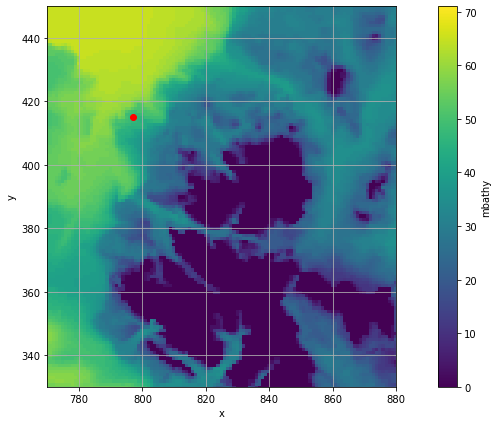

In [124]:
fig, ax = plt.subplots(figsize=(15,7))
bathym.plot()
ax.plot(i_lat[1][0],i_lat[0][0]+7, marker='o', color='r')
ax.plot(i_lat[1][1],i_lat[0][1], marker='o', color='orange')
#ax.plot(idx_moor[0][0],idx_moor[0][1], marker='o', color='g')


'not sure whether np.where give x or y first.....'
#ax.plot(idx_lat[0][0],idx_lat[0][1], marker='o', color='y')
#ax.plot(idx_lat[1][0],idx_lat[1][1], marker='o', color='pink')

#ax.plot(idx_lon[1][0],idx_lon[0][0], marker='o', color='orange')
ax.set_aspect('equal')
ax.grid('on')
ax.set_xlim(770,880)
ax.set_ylim(330,450)

In [38]:
print('OK, funker for p_list[0], må sjekke for de andre også!')

OK, funker for p_list[0], må sjekke for de andre også!
